# Takahashi Diffusion Model Validation

This notebook validates the Takahashi Diffusion Model implementation for financial time series generation.

## Overview
The Takahashi Diffusion Model uses wavelet transformations and DDPM to generate synthetic financial time series with 4 channels (OHLC).

## Test Plan
1. Setup and imports
2. Load and preprocess data (same format as QuantGAN)
3. Initialize Takahashi model
4. Train the model
5. Generate synthetic samples
6. Visualize results


In [1]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Get project root - since notebook is in root directory, use current directory
project_root = Path().resolve()
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.utils.preprocessing_utils import (
    TimeSeriesDataset,
    create_dataloaders,
    preprocess_data
)

from src.utils.configs_utils import get_dataset_cfgs
from src.models.base.base_model import DeepLearningModel
from src.models.non_parametric.takahashi import TakahashiDiffusion


Project root added to sys.path: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main


## Data Preprocessing

Load and preprocess the financial time series data in the same format as QuantGAN validation.


In [2]:
nonparametric_cfg, _ = get_dataset_cfgs()

print(f"Preprocessing normalized data with config: {nonparametric_cfg}")

train_data_np, valid_data_np, _ = preprocess_data(nonparametric_cfg)

batch_size = 32
train_loader_np, valid_loader_np, _ = create_dataloaders(
    train_data_np, valid_data_np, _,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=42,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_np)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_np)}")

num_samples_real, length, num_channels = train_data_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")


Preprocessing normalized data with config: {'ticker': 'AAPL', 'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\AAPL\\AAPL.csv', 'valid_ratio': 0.1, 'test_ratio': 0.1, 'seed': 42}
Preprocessing data for AAPL

[Normalized] Train data shape: (9035, 13, 4)
[Normalized] Valid data shape: (1129, 13, 4)
[Normalized] Number of training batches: 283
[Normalized] Number of validation batches: 36

[Normalized] Inferred model output dimensions: length=13, num_channels=4


## Takahashi Diffusion Model Training

Initialize and train the Takahashi Diffusion model.


In [3]:
print("\n" + "=" * 50)
print("Training Takahashi Diffusion Model")
print("=" * 50)

# Initialize the model with same dimensions as the data
takahashi_model = TakahashiDiffusion(
    length=length,
    num_channels=num_channels,
    num_steps=100,  # Reduced for faster testing
    beta_start=0.0001,
    beta_end=0.02,
    wavelet='haar',
    lr=1e-4
)

print(f"Takahashi Diffusion model initialized on device: {takahashi_model.device}")
print(f"Model: U-Net with {num_channels} input channels, {takahashi_model.num_steps} diffusion steps")
print(f"Total parameters: {sum(p.numel() for p in takahashi_model.model.parameters()):,}")

print("\nTraining Takahashi Diffusion model...")
takahashi_model.fit(train_loader_np, num_epochs=5)  # Reduced epochs for faster testing
print("Takahashi Diffusion training complete.")



Training Takahashi Diffusion Model
Takahashi Diffusion model initialized on device: cpu
Model: U-Net with 4 input channels, 100 diffusion steps
Total parameters: 2,091,276

Training Takahashi Diffusion model...
TakahashiDiffusion epoch 1/5, Loss: 0.218518
TakahashiDiffusion epoch 2/5, Loss: 0.060276
TakahashiDiffusion epoch 3/5, Loss: 0.047506
TakahashiDiffusion epoch 4/5, Loss: 0.045781
TakahashiDiffusion epoch 5/5, Loss: 0.038868
Takahashi Diffusion training complete.


In [4]:
def plot_model_simulations_mean_dt(
    model,
    num_simulations=10, 
    sequence_length=100, 
    feature_idx=None
):
    """
    Generate and plot multiple deep learning model simulations on uniform linear time steps.
    Supports any model that implements a .generate(num_samples, seq_length=...) method and
    outputs tensors of shape (R, l, N).
    """
    if hasattr(model, "eval"):
        model.eval()

    times = np.arange(sequence_length)
    sims = []

    print(f"Generating {num_simulations} simulations of length {sequence_length}...")
    for i in range(num_simulations):
        with torch.no_grad():
            fake_series = model.generate(num_samples=1, seq_length=sequence_length, seed=42+i)
        if isinstance(fake_series, torch.Tensor):
            fake_series = fake_series.cpu().numpy()
        fake_series = fake_series[0]
        sims.append(fake_series)
        print(f"  Simulation {i+1}/{num_simulations} shape: {fake_series.shape}")

    sims = np.stack(sims, axis=0)
    num_channels = sims.shape[2]
    
    print(f"\nAll simulations stacked shape: {sims.shape}")

    if feature_idx is None:
        channels_to_plot = range(num_channels)
    else:
        if feature_idx >= num_channels:
            raise ValueError(f"feature_idx={feature_idx} out of bounds for {num_channels} channels")
        channels_to_plot = [feature_idx]

    channel_names = ["Open", "Close", "High", "Low"]
    
    for ch in channels_to_plot:
        plt.figure(figsize=(12, 6))
        for i in range(num_simulations):
            plt.plot(times, sims[i, :, ch], label=f'Sim {i+1}', alpha=0.7)
        plt.title(f'{num_simulations} Takahashi Diffusion Simulations (Channel {ch}: {channel_names[ch]})')
        plt.xlabel("Time Index")
        plt.ylabel("Feature Value (Normalized)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    # Print statistics
    print(f"\nStatistics across all simulations:")
    for ch in channels_to_plot:
        channel_data = sims[:, :, ch]
        print(f"  Channel {ch} ({channel_names[ch]}):")
        print(f"    Mean: {channel_data.mean():.6f}")
        print(f"    Std: {channel_data.std():.6f}")
        print(f"    Min: {channel_data.min():.6f}")
        print(f"    Max: {channel_data.max():.6f}")


Generating 50 simulations of length 13...
  Simulation 1/50 shape: (13, 4)
  Simulation 2/50 shape: (13, 4)
  Simulation 3/50 shape: (13, 4)
  Simulation 4/50 shape: (13, 4)
  Simulation 5/50 shape: (13, 4)
  Simulation 6/50 shape: (13, 4)
  Simulation 7/50 shape: (13, 4)
  Simulation 8/50 shape: (13, 4)
  Simulation 9/50 shape: (13, 4)
  Simulation 10/50 shape: (13, 4)
  Simulation 11/50 shape: (13, 4)
  Simulation 12/50 shape: (13, 4)
  Simulation 13/50 shape: (13, 4)
  Simulation 14/50 shape: (13, 4)
  Simulation 15/50 shape: (13, 4)
  Simulation 16/50 shape: (13, 4)
  Simulation 17/50 shape: (13, 4)
  Simulation 18/50 shape: (13, 4)
  Simulation 19/50 shape: (13, 4)
  Simulation 20/50 shape: (13, 4)
  Simulation 21/50 shape: (13, 4)
  Simulation 22/50 shape: (13, 4)
  Simulation 23/50 shape: (13, 4)
  Simulation 24/50 shape: (13, 4)
  Simulation 25/50 shape: (13, 4)
  Simulation 26/50 shape: (13, 4)
  Simulation 27/50 shape: (13, 4)
  Simulation 28/50 shape: (13, 4)
  Simulation 29

C:\Users\14165\AppData\Local\Temp\ipykernel_11592\753348049.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


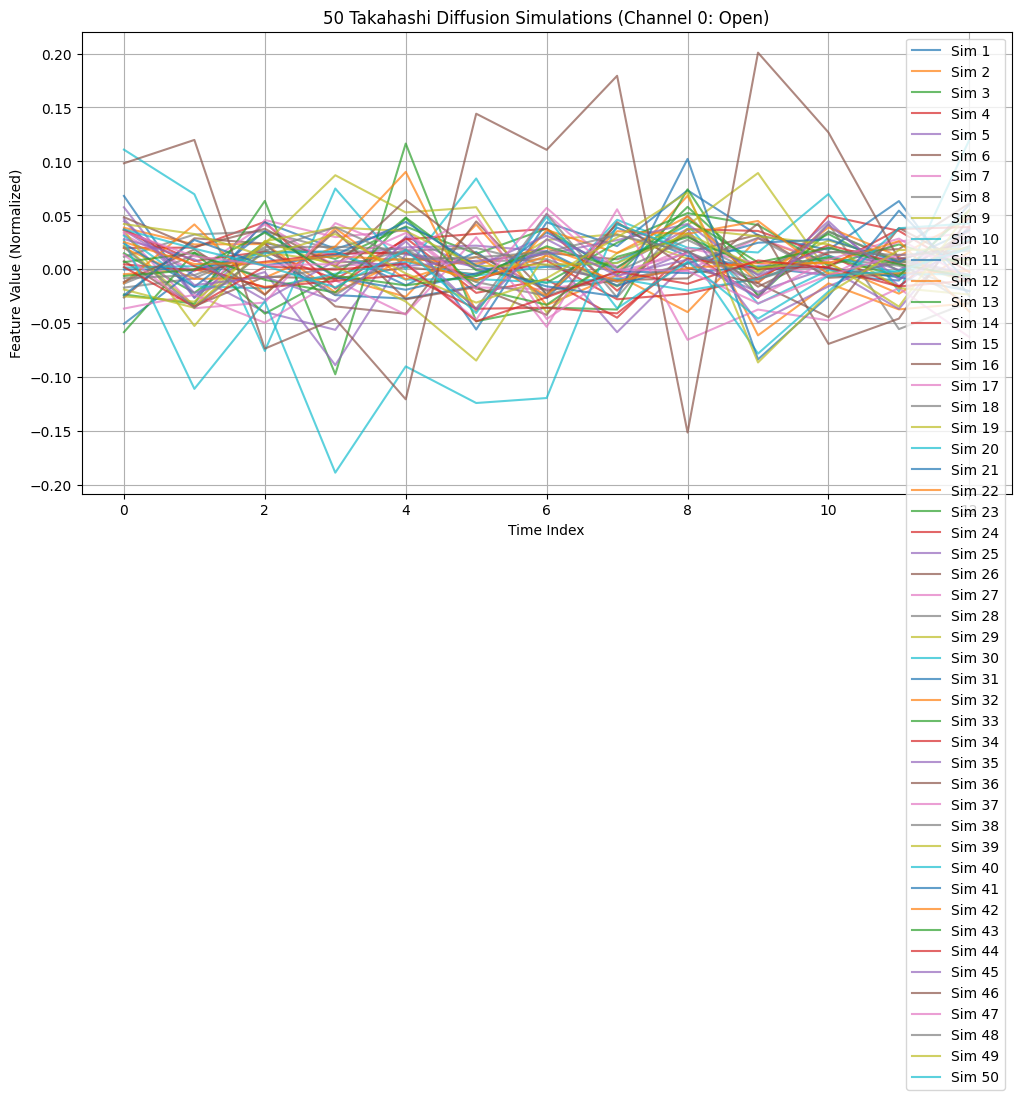

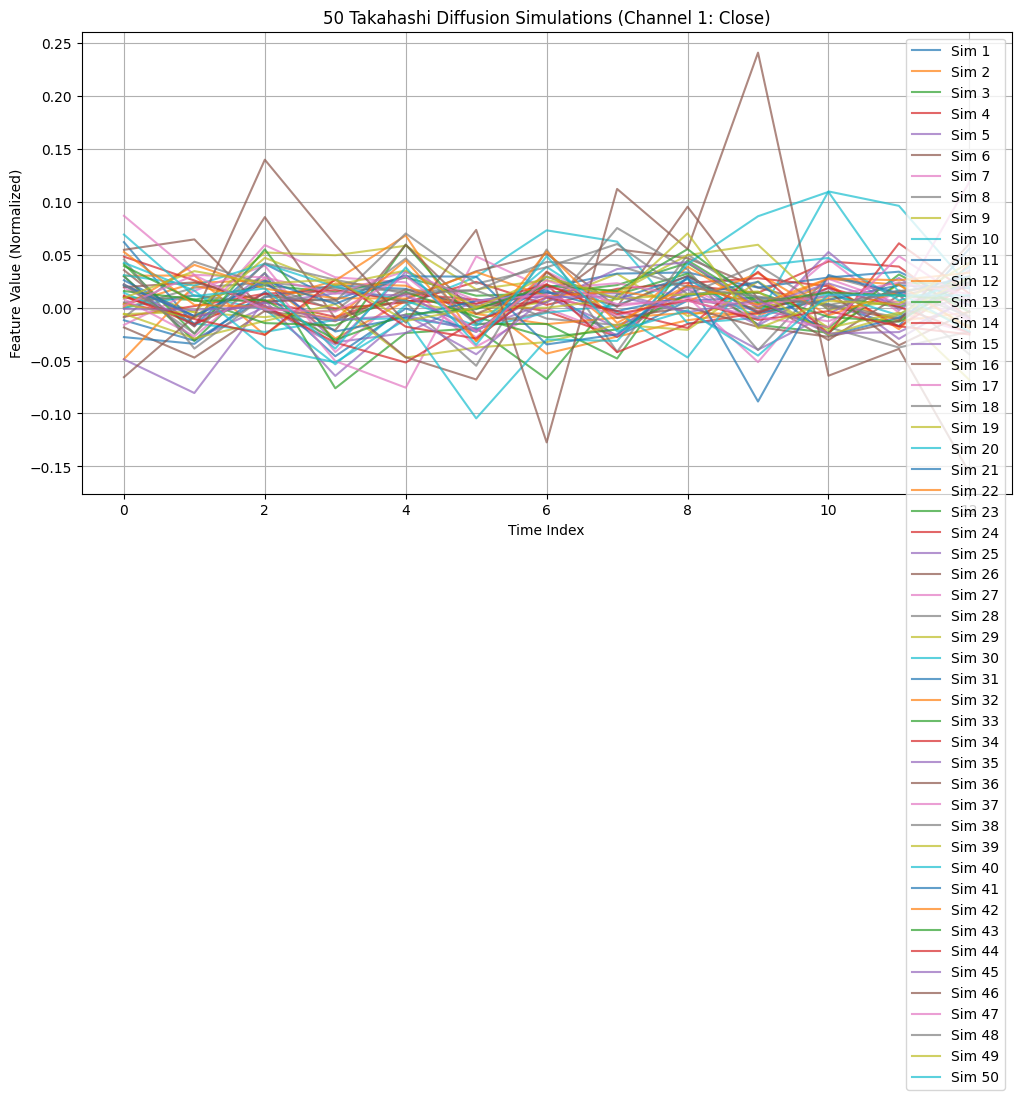

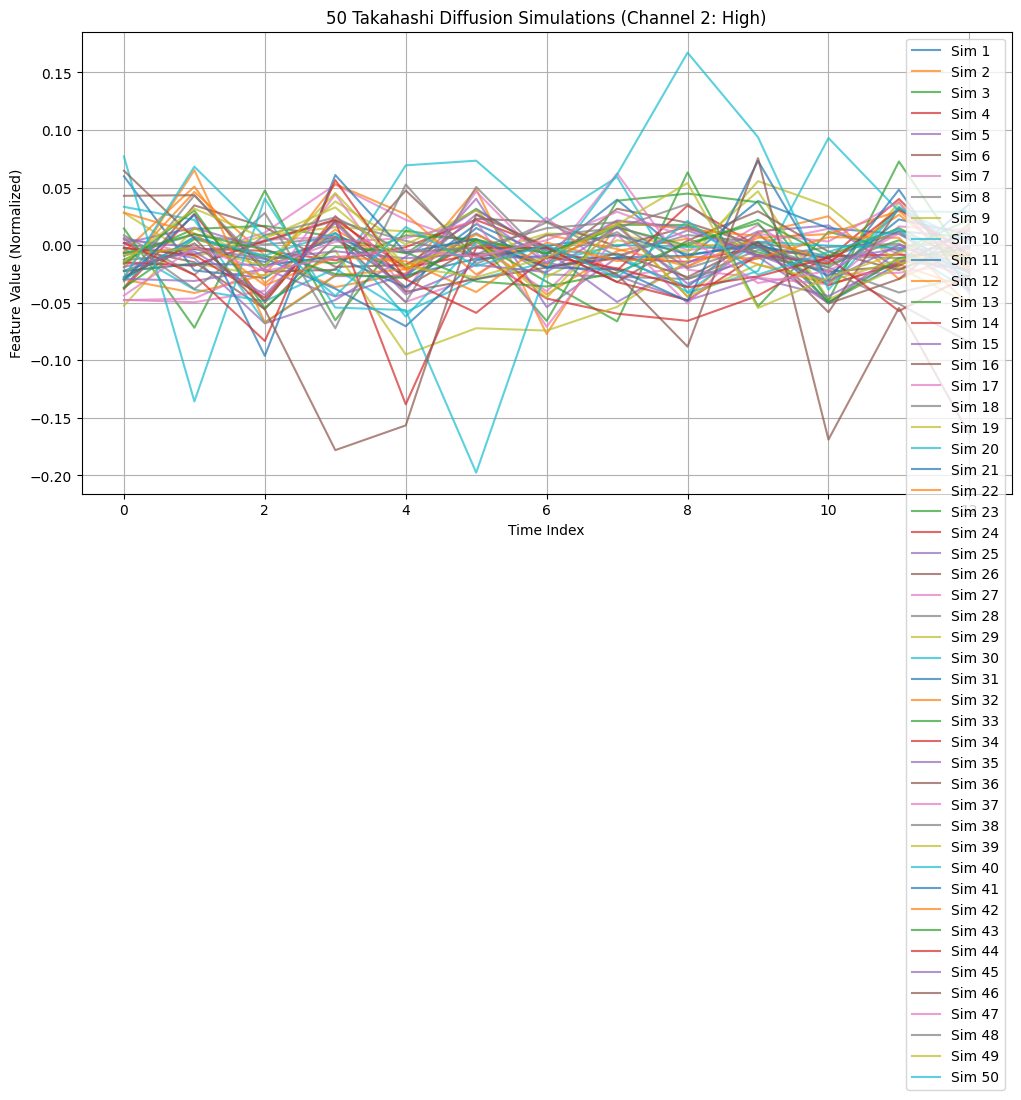

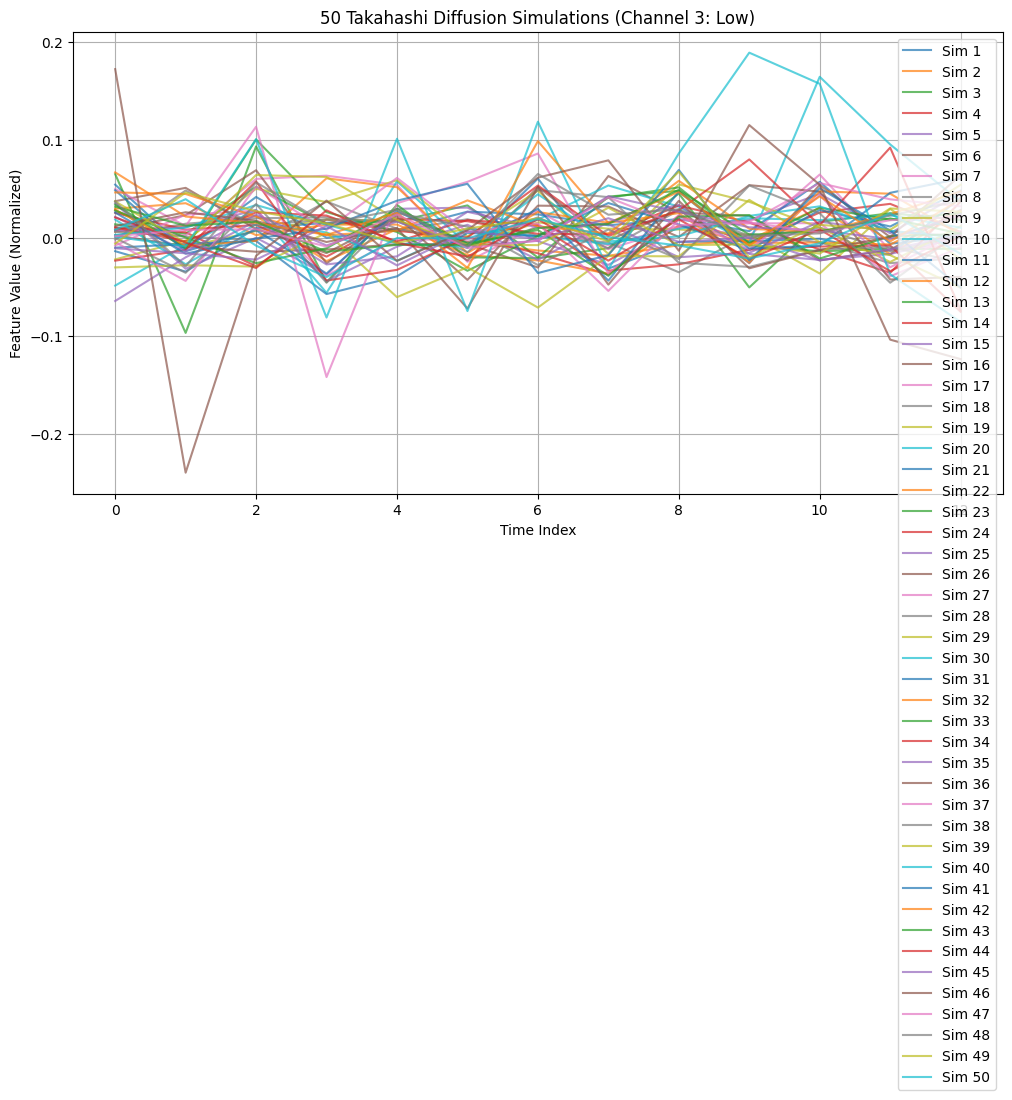


Statistics across all simulations:
  Channel 0 (Open):
    Mean: 0.005413
    Std: 0.036460
    Min: -0.188560
    Max: 0.200804
  Channel 1 (Close):
    Mean: 0.006690
    Std: 0.032128
    Min: -0.155928
    Max: 0.240726
  Channel 2 (High):
    Mean: -0.008785
    Std: 0.034224
    Min: -0.197680
    Max: 0.167110
  Channel 3 (Low):
    Mean: 0.008368
    Std: 0.035659
    Min: -0.239655
    Max: 0.188809


In [9]:
# Generate synthetic samples using the trained model
plot_model_simulations_mean_dt(model=takahashi_model, num_simulations=50, sequence_length=13)


## Compare with Real Data

Generate a visualization comparing synthetic samples with real validation data.


Generating samples for comparison...
Generated samples shape: torch.Size([3, 13, 4])
Comparison data shape: (3, 13, 4)


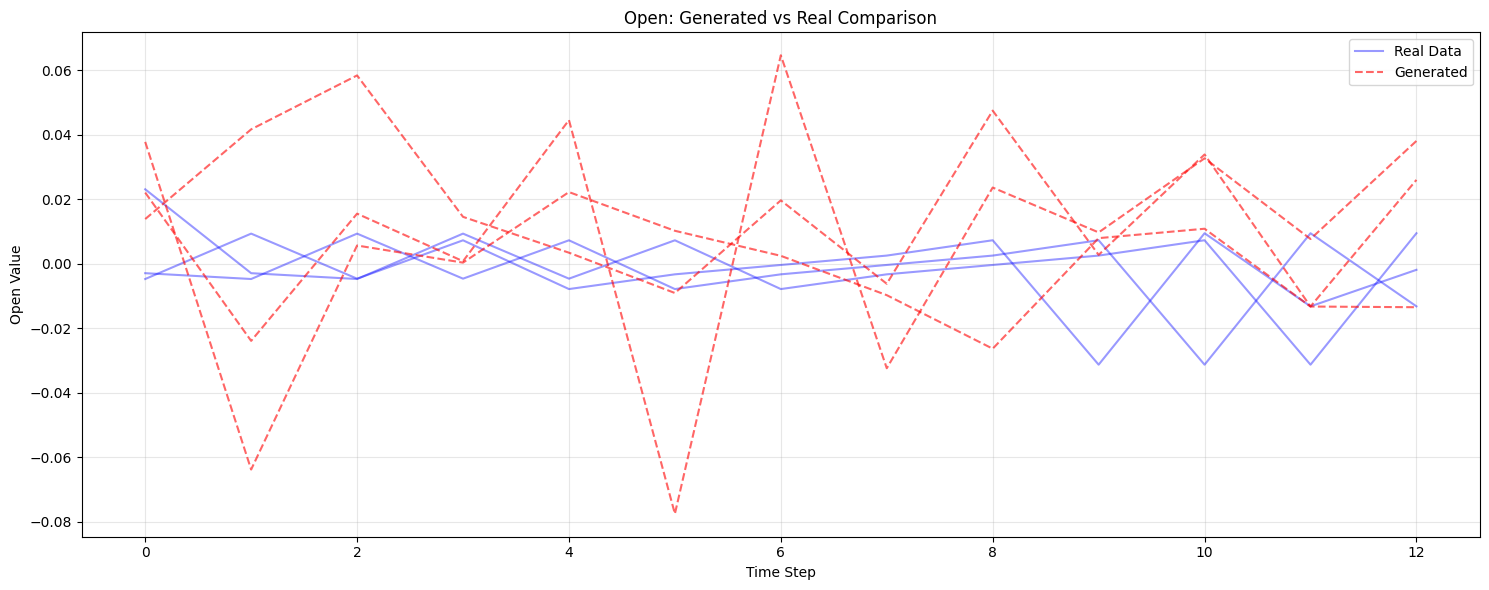

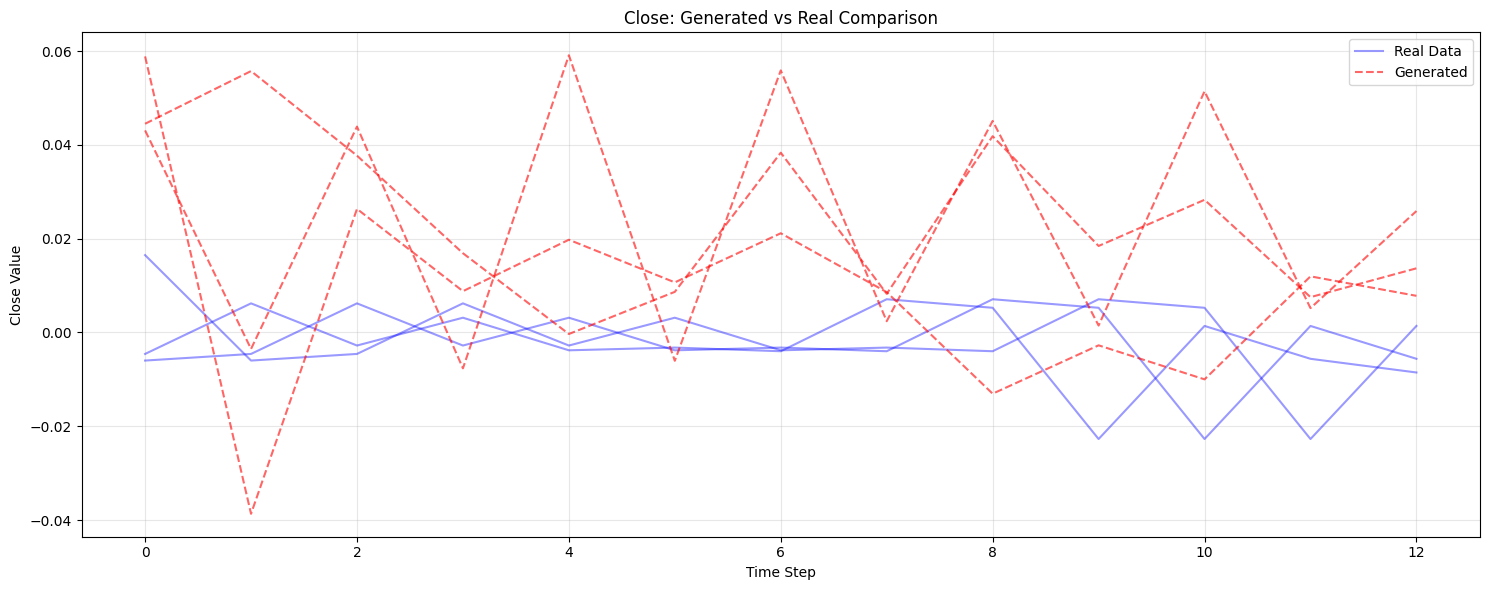

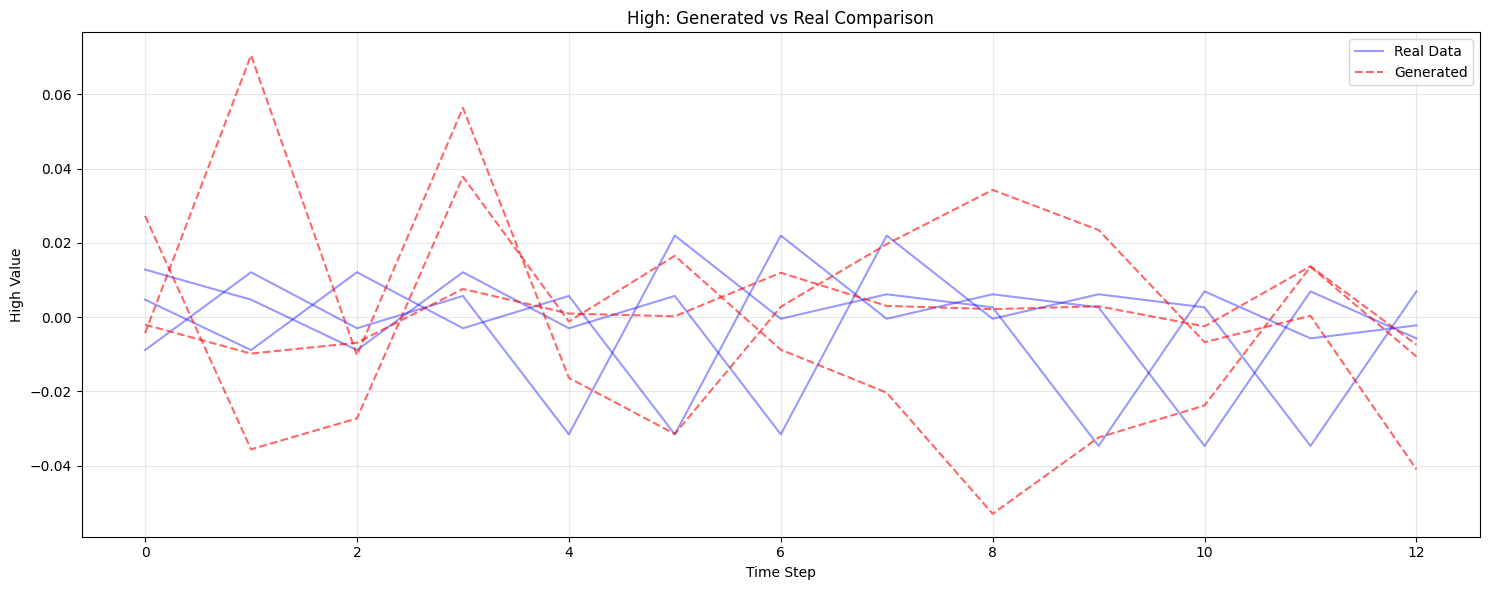

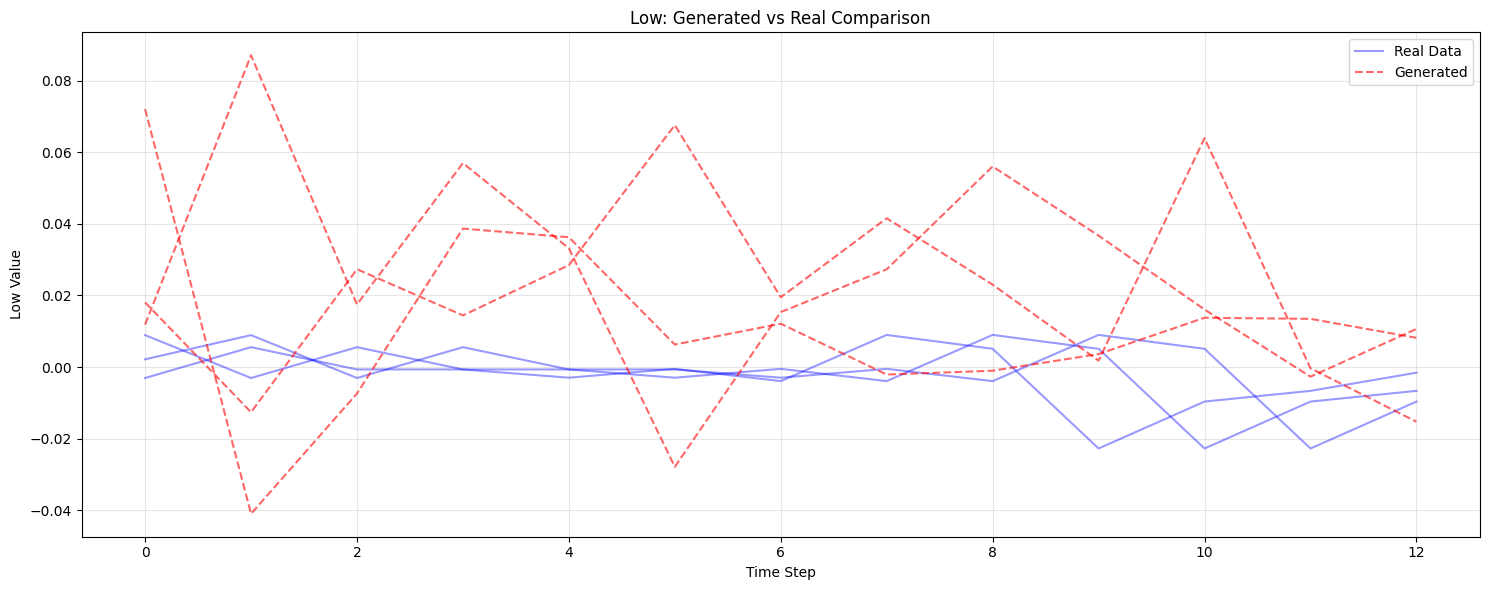

In [6]:
def plot_generated_vs_real_comparison(generated_data, real_data, num_samples_to_show=3):
    """
    Plot comparison between generated and real data.
    """
    channel_names = ["Open", "Close", "High", "Low"]
    num_channels = generated_data.shape[-1]
    
    for c in range(num_channels):
        plt.figure(figsize=(15, 6))
        
        # Plot real data (validation set)
        for i in range(min(num_samples_to_show, real_data.shape[0])):
            y_real = real_data[i, :, c]
            plt.plot(
                range(len(y_real)), y_real,
                alpha=0.4, linestyle="-", color='blue',
                label="Real Data" if i == 0 else None
            )
        
        # Plot generated data
        for i in range(min(num_samples_to_show, generated_data.shape[0])):
            y_fake = generated_data[i, :, c]
            plt.plot(
                range(len(y_fake)), y_fake,
                alpha=0.6, linestyle="--", color='red',
                label="Generated" if i == 0 else None
            )
        
        plt.title(f"{channel_names[c]}: Generated vs Real Comparison")
        plt.xlabel("Time Step")
        plt.ylabel(f"{channel_names[c]} Value")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Generate samples and compare
print("Generating samples for comparison...")
with torch.no_grad():
    generated_samples = takahashi_model.generate(num_samples=3, seq_length=length, seed=42)

print(f"Generated samples shape: {generated_samples.shape}")

# Use validation data for comparison
comparison_data = valid_data_np[:3]  # First 3 validation samples
print(f"Comparison data shape: {comparison_data.shape}")

plot_generated_vs_real_comparison(generated_samples, comparison_data, num_samples_to_show=3)


## Model Validation Summary

Verify the model outputs are in the correct format.


In [7]:
print("\n" + "=" * 50)
print("Model Validation Summary")
print("=" * 50)

# Test generation with different parameters
test_samples_1 = takahashi_model.generate(num_samples=10, seq_length=length, seed=42)
print(f"✓ Test 1: Generated {test_samples_1.shape[0]} samples of length {test_samples_1.shape[1]} with {test_samples_1.shape[2]} channels")
print(f"  Expected shape: (10, {length}, {num_channels})")
print(f"  Actual shape: {test_samples_1.shape}")
assert test_samples_1.shape == (10, length, num_channels), "Shape mismatch!"

# Test with different sequence length
test_length = 50
test_samples_2 = takahashi_model.generate(num_samples=5, seq_length=test_length, seed=42)
print(f"\n✓ Test 2: Generated {test_samples_2.shape[0]} samples of length {test_samples_2.shape[1]} with {test_samples_2.shape[2]} channels")
print(f"  Expected shape: (5, {test_length}, {num_channels})")
print(f"  Actual shape: {test_samples_2.shape}")
assert test_samples_2.shape == (5, test_length, num_channels), "Shape mismatch!"

# Check output type
print(f"\n✓ Test 3: Output type check")
print(f"  Type: {type(test_samples_1)}")
assert isinstance(test_samples_1, torch.Tensor), "Output is not a torch.Tensor!"

# Check values are finite
print(f"\n✓ Test 4: Value validity check")
print(f"  All values finite: {torch.isfinite(test_samples_1).all().item()}")
print(f"  Mean: {test_samples_1.mean().item():.6f}")
print(f"  Std: {test_samples_1.std().item():.6f}")
assert torch.isfinite(test_samples_1).all(), "Non-finite values detected!"

print("\n" + "=" * 50)
print("✓ All validation tests passed!")
print("=" * 50)



Model Validation Summary
✓ Test 1: Generated 10 samples of length 13 with 4 channels
  Expected shape: (10, 13, 4)
  Actual shape: torch.Size([10, 13, 4])

✓ Test 2: Generated 5 samples of length 50 with 4 channels
  Expected shape: (5, 50, 4)
  Actual shape: torch.Size([5, 50, 4])

✓ Test 3: Output type check
  Type: <class 'torch.Tensor'>

✓ Test 4: Value validity check
  All values finite: True
  Mean: 0.004070
  Std: 0.028830

✓ All validation tests passed!
